# 1.5 signac-flow Ideal Gas Example

## About

This notebook contains a minimal example for running a signac-flow project from scratch.
The example demonstrates how to compare an ideal gas with a Lennard-Jones fluid by calculating a p-V phase diagram.

## Author

Carl Simon Adorf

## Before you start

Make sure you installed signac and signac-flow, e.g., with:

```
conda install -c conda-forge signac signac-flow
```

In [1]:
import flow
import numpy as np
import signac

# Enter the signac project directory
project = signac.init_project("projects/tutorial-signac-flow")

We want to generate a pressure-volume (p-V) phase diagram for an ideal gas.

We define a function to calculate the result for a given state point:

In [2]:
def V_idg(N, p, kT):
    return N * kT / p

For this demonstration we will specialize a `flow.FlowProject` to manage our simple *workflow*.

The workflow will contain one label and one operation.
 - The label function allows us to *label* our jobs in the project *status*. This is especially important for understanding the state of large projects with expensive operations.
 - The operation function `compute_volume` is defined with a postcondition and will act on each job. This operation is eligible for execution if its postcondition is unmet (`False`).

In [3]:
class MyProject(flow.FlowProject):
    pass


@MyProject.label
def estimated(job):
    return "V" in job.document


@MyProject.post(estimated)
@MyProject.operation
def compute_volume(job):
    job.document["V"] = V_idg(**job.statepoint())

We need to use the `get_project()` *class method* to get a project handle for this special project class.

In [4]:
project = MyProject.get_project("projects/tutorial-signac-flow")

Now it's time to actually generate some data! Let's initialize the data space!


In [5]:
for p in np.linspace(0.5, 5.0, 10):
    sp = dict(N=1728, kT=1.0, p=float(p))
    job = project.open_job(sp)
    print(job.id)
    job.init()

a14ee3104f26974b22bb84f62500c84d
55d4d6ebbc04a1f8a259a2c5de197328
4b299db86ff480f92e520eac91112108
26e2f19b5b211edb80ebe60a5a62bd75
75c10d0fa7a4f4b4742ce5e9c119e8bd
46859989efcfd89653fa65db2375884b
f3f3c351f81acd2140edd239b9183af4
b38e30524c2c36e3ebfe50481eb91992
bb277ac022ce744d38f9e87c1fabe08c
6f9bc79d670e42d4a40041ce7be9cdaf


The `print_status()` function allows to get a quick overview of our project's *status*:

In [6]:
project.print_status(detailed=True)

Fetching status:   0%|          | 0/10 [00:00<?, ?it/s]

Fetching labels:   0%|          | 0/10 [00:00<?, ?it/s]


Overview: 10 jobs/aggregates, 10 jobs/aggregates with eligible operations.

label
-------


operation/group      number of eligible jobs  submission status
-----------------  -------------------------  -------------------
compute_volume                            10  [U]: 10

Detailed View:

job id                            operation/group     labels
--------------------------------  ------------------  --------
26e2f19b5b211edb80ebe60a5a62bd75  compute_volume [U]
46859989efcfd89653fa65db2375884b  compute_volume [U]
4b299db86ff480f92e520eac91112108  compute_volume [U]
55d4d6ebbc04a1f8a259a2c5de197328  compute_volume [U]
6f9bc79d670e42d4a40041ce7be9cdaf  compute_volume [U]
75c10d0fa7a4f4b4742ce5e9c119e8bd  compute_volume [U]
a14ee3104f26974b22bb84f62500c84d  compute_volume [U]
b38e30524c2c36e3ebfe50481eb91992  compute_volume [U]
bb277ac022ce744d38f9e87c1fabe08c  compute_volume [U]
f3f3c351f81acd2140edd239b9183af4  compute_volume [U]

[U]:unknown [R]:registered [I]:inactive [S]:submitt

The next cell will attempt to execute all operations by cycling through jobs and operations until no *next operations* are defined anymore.

We limit the max. number of cycles to prevent accidental infinite loops, the number of cycles is arbitrary.

In [7]:
project.run(num_passes=3)

Let's double check the project status.

In [8]:
project.print_status(detailed=True)

Fetching status:   0%|          | 0/10 [00:00<?, ?it/s]

Fetching labels:   0%|          | 0/10 [00:00<?, ?it/s]


Overview: 10 jobs/aggregates, 0 jobs/aggregates with eligible operations.

label      ratio
---------  ----------------------------------------------------------
estimated  |████████████████████████████████████████| 10/10 (100.00%)

operation/group
-----------------


Detailed View:

job id                            operation/group    labels
--------------------------------  -----------------  ---------
26e2f19b5b211edb80ebe60a5a62bd75  [ ]                estimated
46859989efcfd89653fa65db2375884b  [ ]                estimated
4b299db86ff480f92e520eac91112108  [ ]                estimated
55d4d6ebbc04a1f8a259a2c5de197328  [ ]                estimated
6f9bc79d670e42d4a40041ce7be9cdaf  [ ]                estimated
75c10d0fa7a4f4b4742ce5e9c119e8bd  [ ]                estimated
a14ee3104f26974b22bb84f62500c84d  [ ]                estimated
b38e30524c2c36e3ebfe50481eb91992  [ ]                estimated
bb277ac022ce744d38f9e87c1fabe08c  [ ]                estimated
f3f3c351f81acd2140edd239

After running all operations we can make a brief examination of the collected data.

In [9]:
for job in project:
    print(job.statepoint()["p"], job.document.get("V"))

3.0 576.0
1.5 1152.0
4.5 384.0
2.5 691.2
3.5 493.7142857142857
2.0 864.0
5.0 345.6
0.5 3456.0
4.0 432.0
1.0 1728.0


For a better presentation of the results we need to aggregate all results and sort them by pressure.

[3456.0, 1728.0, 1152.0, 864.0, 691.2, 576.0, 493.7142857142857, 432.0, 384.0, 345.6]


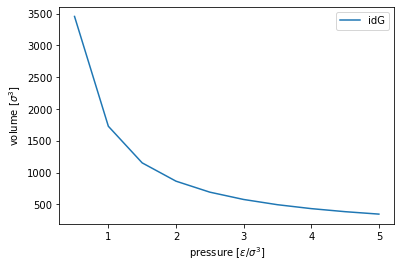

In [10]:
%matplotlib inline

from matplotlib import pyplot as plt

V = {}

for job in project:
    V[job.statepoint()["p"]] = job.document["V"]

p = sorted(V.keys())
V = [V[p_] for p_ in p]
print(V)

plt.plot(p, V, label="idG")
plt.xlabel(r"pressure [$\epsilon / \sigma^3$]")
plt.ylabel(r"volume [$\sigma^3$]")
plt.legend()
plt.show()

Uncomment and execute the following line to remove all data and start over.

In [11]:
# %rm -r projects/tutorial-signac-flow/workspace